In [0]:
!pip install shap lime pdpbox catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/275.7 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━ 204.8/275.7 kB 5.9 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for pdpbox from https://files.pythonhosted.org/packages/1f/2e/8f115e0c514f2057fd8a99a01f52a5cd7d6952adf98dcffae086c2bccff6/PDPbox-0.3.0-py3-none-any.whl.metadata
  Obtaining dependency information for catboost from https://files.pythonhosted.org/packages/74/0c/cff2c8fa0ccac3df0589334846d470c76295f7f3a0cc5954d87d81b1bdcc/catboost-1.2.7-cp311-cp311-manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for pqdm>=0.2.0 from https://files.pythonhosted.org/packages/9e/b7/720988acdc9b5805cd1ef311aa75d6fd1c5438b87f4add1ec8d11f78d63b/pqdm-0.2.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for py

In [0]:
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, rand, isnan, year, month, expr, radians, sin, cos, atan2, sqrt, lit, udf, datediff, to_date
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report, precision_recall_curve, auc, f1_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import lime
import lime.lime_tabular
from pdpbox import pdp, info_plots
from scipy.stats import ks_2samp
from catboost import CatBoostClassifier, Pool
import joblib
import warnings
import math

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fe02ed9b4c0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'


In [0]:
# Define Haversine formula as a UDF (distance in miles)
def haversine_miles(lat1, lon1, lat2, lon2):
    try:
        if lat1 is None or lon1 is None or lat2 is None or lon2 is None:
            return None  # Return None if any coordinate is missing

        R = 3958.8  # Earth radius in miles

        # Convert degrees to radians
        lat1, lon1, lat2, lon2 = map(float, [lat1, lon1, lat2, lon2])
        lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

        # Haversine formula
        dlat = lat2 - lat1
        dlon = lon1 - lon2
        a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

        return abs(R * c)  # Distance in miles, always positive
    except ValueError:
        return None  # Return None if there is a ValueError

# Register as a PySpark UDF
haversine_miles_udf = udf(haversine_miles, DoubleType())

# Calculate distance only if provider_flag = 1 and cast as double
df = spark.sql('''select * from dev_adb.ifp_churn.data_augment_preprocessed''')

# Calculate median distance
median_distance = df.filter(col("provider_flag") == 1).select(
    haversine_miles_udf(
        col("LATITUDE"), col("LONGITUDE"), col("HOME_LATITUDE"), col("HOME_LONGITUDE")
    ).alias("distance").cast("double")
).approxQuantile("distance", [0.5], 0.01)[0]

df = df.withColumn(
    "PCP_DISTANCE",
    when(
        col("provider_flag") == 1,
        haversine_miles_udf(
            col("LATITUDE"), col("LONGITUDE"), col("HOME_LATITUDE"), col("HOME_LONGITUDE")
        ).cast("double")
    ).otherwise(lit(median_distance).cast("double"))  # Assign median value if provider_flag != 1
)

# Generate summary statistics for PCP_DISTANCE
summary_stats = df.select("PCP_DISTANCE").summary()
display(summary_stats)

# Detect outliers for PCP_DISTANCE
distance_quantiles = df.approxQuantile("PCP_DISTANCE", [0.01, 0.95], 0.01)
df = df.filter((col("PCP_DISTANCE") >= distance_quantiles[0]) & (col("PCP_DISTANCE") <= distance_quantiles[1]))

summary,PCP_DISTANCE
count,2974502
mean,274.36230106475426
stddev,1403.0357848242597
min,0.018570725454224026
25%,9.090360424907434
50%,9.090360424907434
75%,9.090360424907434
max,10347.716513772053


In [0]:
# Remove distance outliers
distance_quantiles = df.approxQuantile("PCP_DISTANCE", [0.01, 0.95], 0.01)
df = df.filter((col("PCP_DISTANCE") >= distance_quantiles[0]) & (col("PCP_DISTANCE") <= distance_quantiles[1]))

df = df.withColumn(
    "TENURE",
    datediff(to_date(col("LAST_ELIG_MONTH_END_DT")), to_date(col("FIRST_ELIG_MONTH_START_DT")))
)

# Remove tenure outliers (top 5%)
quantiles = df.approxQuantile("TENURE", [0.01, 0.95], 0.01)
df = df.filter((col("TENURE") >= quantiles[0]) & (col("TENURE") <= quantiles[1]))

In [0]:
# Drop columns with PII info, repeated info, and latitude/longitude
drop_cols = [col for col in df.columns if "HASH" in col or 
                "ID" in col or 
                "DT" in col or 
                "DATE" in col or 
                "NAME" in col or 
                "PHONE" in col or 
                "EMAIL" in col or 
                "ADDRESS" in col or 
                "ADDR" in col or 
                "FIPS" in col or 
                "TRACTCODE" in col or 
                "CENSUS" in col or
                "HOME" in col or
                "MAILING" in col or
                "ZIP" in col or
                "LATITUDE" in col or
                "LONGITUDE" in col or
                "CITY" in col or
                "PRIMARY" in col or
                "SECONDARY" in col or
                "PROV" in col]

dft = df.filter(col('open_enrollment_cycle') == '2024').drop(*drop_cols).drop(col('survival_flag'),col('SUBSCRIBER_KEY'),col('MEMBER_DOB'),col('AGE_IN_DAYS'),col('LANG_CD'),col('REL_BIRTHINFO'), col('RACE_CD'), col('ETHNIC_CD'), col('STUDY_PERIOD'), col('HCPK'), col('open_enrollment_cycle'),('COA'),('LOB1'),('LOB2'),('LOB3'),('LOB4'),('LOB5'),('LOB6'),('LOB7'),('MOBILE_COUNTRY_CODE'),('NPI'),('TIN'),('VERIF_STATUS'),('URBANIZATION'))

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = dft.toPandas()

# Print confirmation
num_rows = dft.count()
num_cols = len(dft.columns)
print(f"Shape deleting columns: ({num_rows}, {num_cols})")

Shape deleting columns: (685198, 490)


In [0]:
# Define target and feature columns
target_col = "churn_flag"
feature_cols = [col for col in pandas_df.columns if col != target_col]

# Split data into features (X) and target (y)
X = pandas_df[feature_cols]
y = pandas_df[target_col]

# Identify categorical columns
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

# Convert categorical columns to string type
for col in categorical_cols:
    X[col] = X[col].astype(str)

# Fill missing values with -999
X = X.fillna(-999) 

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Calculate class weights for handling imbalanced data
class_weights = {
    0: len(y_train) / (2 * (y_train == 0).sum()),
    1: len(y_train) / (2 * (y_train == 1).sum())
}

# Create CatBoost Pools for training and testing data
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_cols)
test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_cols)

# Initialize and train CatBoost Classifier
catboost_model = CatBoostClassifier()
catboost_model.fit(train_pool)

# Get feature importance from the trained model
feature_importance = catboost_model.get_feature_importance()
feature_importance_df = pd.DataFrame({"Feature": feature_cols, "Importance": feature_importance})

# Get top 30 important features
top_30_features = feature_importance_df.sort_values(by="Importance", ascending=False).head(30)["Feature"].tolist()
print(top_30_features)

Learning rate set to 0.152211
0:	learn: 0.5773398	total: 282ms	remaining: 4m 41s
1:	learn: 0.4899214	total: 456ms	remaining: 3m 47s
2:	learn: 0.4312932	total: 649ms	remaining: 3m 35s
3:	learn: 0.3922894	total: 818ms	remaining: 3m 23s
4:	learn: 0.3662284	total: 1.01s	remaining: 3m 21s
5:	learn: 0.3480711	total: 1.19s	remaining: 3m 17s
6:	learn: 0.3356126	total: 1.35s	remaining: 3m 11s
7:	learn: 0.3271329	total: 1.52s	remaining: 3m 8s
8:	learn: 0.3211882	total: 1.64s	remaining: 3m
9:	learn: 0.3170489	total: 1.8s	remaining: 2m 58s
10:	learn: 0.3136281	total: 1.96s	remaining: 2m 56s
11:	learn: 0.3111157	total: 2.13s	remaining: 2m 55s
12:	learn: 0.3091461	total: 2.29s	remaining: 2m 54s
13:	learn: 0.3077936	total: 2.45s	remaining: 2m 52s
14:	learn: 0.3053365	total: 2.63s	remaining: 2m 52s
15:	learn: 0.3044961	total: 2.79s	remaining: 2m 51s
16:	learn: 0.3039200	total: 2.94s	remaining: 2m 49s
17:	learn: 0.3033153	total: 3.1s	remaining: 2m 49s
18:	learn: 0.3029815	total: 3.27s	remaining: 2m 48s

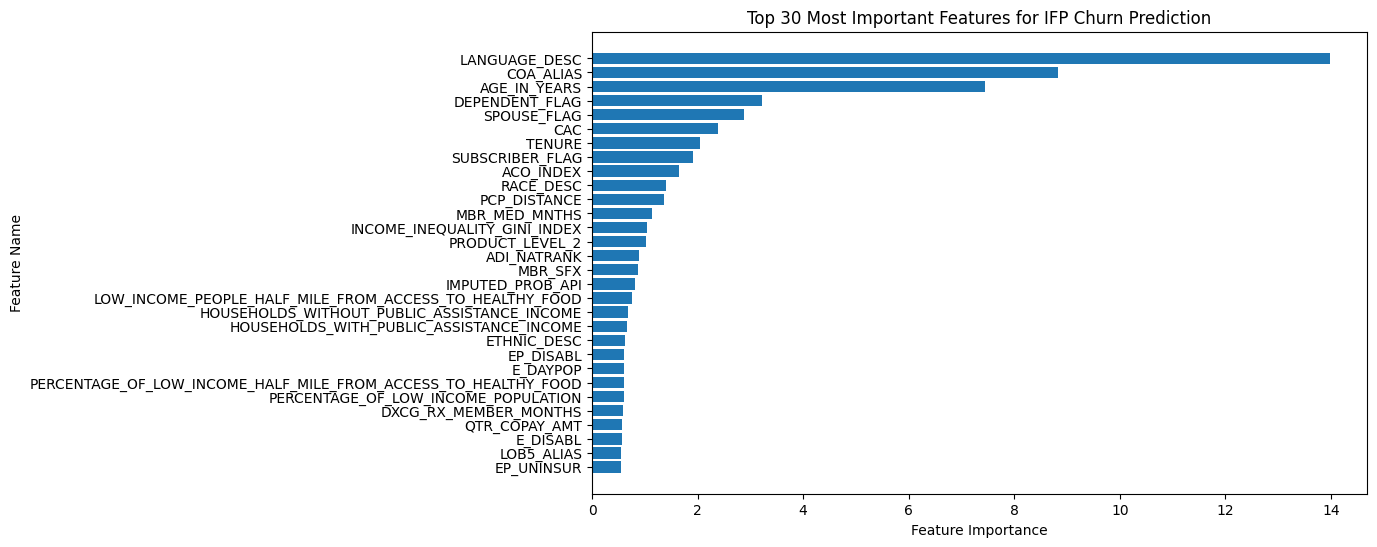

In [0]:
# Feature Importance Plot
top_df = feature_importance_df.sort_values(by="Importance", ascending=False).head(30)
plt.figure(figsize=(10, 6))
plt.barh(top_df.head(30)['Feature'], top_df.head(30)['Importance'], align='center')
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Top 30 Most Important Features for IFP Churn Prediction")
plt.gca().invert_yaxis()
plt.show()

In [0]:
top_df

,Feature,Importance
20,LANGUAGE_DESC,13.985435
330,COA_ALIAS,8.831157
5,AGE_IN_YEARS,7.443329
9,DEPENDENT_FLAG,3.218113
8,SPOUSE_FLAG,2.871215
331,CAC,2.380694
488,TENURE,2.054312
7,SUBSCRIBER_FLAG,1.921390
369,ACO_INDEX,1.640131
18,RACE_DESC,1.401175


In [0]:
# Filter dataset to keep only the top 30 features
X_train_top = X_train[top_30_features]
X_test_top = X_test[top_30_features]

# Update categorical columns list for the top 30 features
categorical_cols_top = [col for col in categorical_cols if col in top_30_features]
print(categorical_cols_top)

# Use Pool object with top 30 features
train_pool_top = Pool(data=X_train_top, label=y_train, cat_features=categorical_cols_top)
test_pool_top = Pool(data=X_test_top, label=y_test, cat_features=categorical_cols_top)

['MBR_SFX', 'RACE_DESC', 'ETHNIC_DESC', 'LANGUAGE_DESC', 'COA_ALIAS', 'CAC', 'PRODUCT_LEVEL_2', 'LOB5_ALIAS', 'ACO_INDEX']


In [0]:
# Parameter tuning to optimize recall using Optuna
import optuna
from optuna.integration import CatBoostPruningCallback

def objective(trial):
    param = {
        "depth": trial.suggest_int("depth", 4, 6),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
        "iterations": trial.suggest_int("iterations", 500, 1000),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 3, 5),
        "border_count": trial.suggest_categorical("border_count", [32, 64]),
        "loss_function": "Logloss",
        "eval_metric": "Recall",
        "verbose": 0,
        "thread_count": -1
    }
    
    catboost_model_tuned = CatBoostClassifier(**param)
    catboost_model_tuned.fit(
        X_train_top, y_train,
        eval_set=(X_test_top, y_test),
        cat_features=categorical_cols_top,
        early_stopping_rounds=100,
        verbose=0,
        callbacks=[CatBoostPruningCallback(trial, "Recall")]
    )
    
    y_pred_prob = catboost_model_tuned.predict_proba(X_test_top)[:, 1]
    recall = recall_score(y_test, (y_pred_prob > 0.5).astype(int))
    return recall

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, n_jobs=-1)

best_params = study.best_params
print("Best Parameters Found:", best_params)

[I 2025-03-27 03:29:11,549] A new study created in memory with name: no-name-901c3cdb-59ba-429f-a5f1-d7db0fdb30fc
[I 2025-03-27 03:30:12,690] Trial 5 finished with value: 0.18174507438681142 and parameters: {'depth': 6, 'learning_rate': 0.008478929755567225, 'iterations': 709, 'l2_leaf_reg': 3, 'border_count': 32}. Best is trial 5 with value: 0.18174507438681142.
[I 2025-03-27 03:30:13,808] Trial 1 finished with value: 0.18161104409596568 and parameters: {'depth': 6, 'learning_rate': 0.011152336756676071, 'iterations': 721, 'l2_leaf_reg': 5, 'border_count': 32}. Best is trial 5 with value: 0.18174507438681142.
[I 2025-03-27 03:30:14,766] Trial 9 finished with value: 0.1796676048787026 and parameters: {'depth': 6, 'learning_rate': 0.01383740793825181, 'iterations': 697, 'l2_leaf_reg': 3, 'border_count': 64}. Best is trial 5 with value: 0.18174507438681142.
[I 2025-03-27 03:30:16,204] Trial 7 finished with value: 0.17960058973327972 and parameters: {'depth': 4, 'learning_rate': 0.0105274

Best Parameters Found: {'depth': 4, 'learning_rate': 0.017815126597942876, 'iterations': 677, 'l2_leaf_reg': 3, 'border_count': 32}


In [0]:
# Train CatBoost with best parameters to optimize recall
catboost_final = CatBoostClassifier(
    **best_params,
    random_strength=5,  # Adds more randomness to avoid memorization
    verbose=100,
    loss_function="Logloss",  # Use Logloss for classification
    class_weights=class_weights,
    thread_count=-1,
    eval_metric="Recall"  # Optimize for recall
)
catboost_final.fit(train_pool_top, eval_set=test_pool_top, metric_period=100)

# Get predictions
y_pred_prob = catboost_final.predict_proba(test_pool_top)[:, 1]

0:	learn: 0.2206306	test: 0.2249698	best: 0.2249698 (0)	total: 74.4ms	remaining: 50.3s
100:	learn: 0.4540444	test: 0.4570433	best: 0.4570433 (100)	total: 4.85s	remaining: 27.7s
200:	learn: 0.4709489	test: 0.4739311	best: 0.4739311 (200)	total: 10.2s	remaining: 24.2s
300:	learn: 0.4840336	test: 0.4863289	best: 0.4863289 (300)	total: 15.2s	remaining: 19s
400:	learn: 0.4959288	test: 0.4991958	best: 0.4991958 (400)	total: 20.5s	remaining: 14.1s
500:	learn: 0.5038031	test: 0.5048251	best: 0.5048251 (500)	total: 25.7s	remaining: 9.03s
600:	learn: 0.5105549	test: 0.5103203	best: 0.5103203 (600)	total: 30.9s	remaining: 3.91s
676:	learn: 0.5122135	test: 0.5128669	best: 0.5128669 (676)	total: 35s	remaining: 0us

bestTest = 0.5128669079
bestIteration = 676



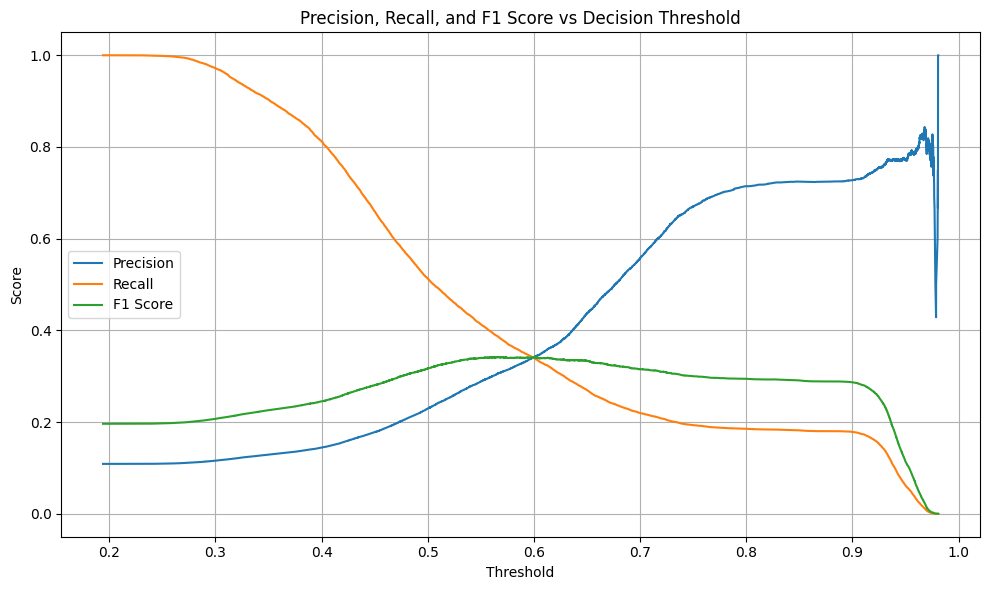

In [0]:
# Compute precision-recall values
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Calculate F1 scores
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Plot the curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs Decision Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

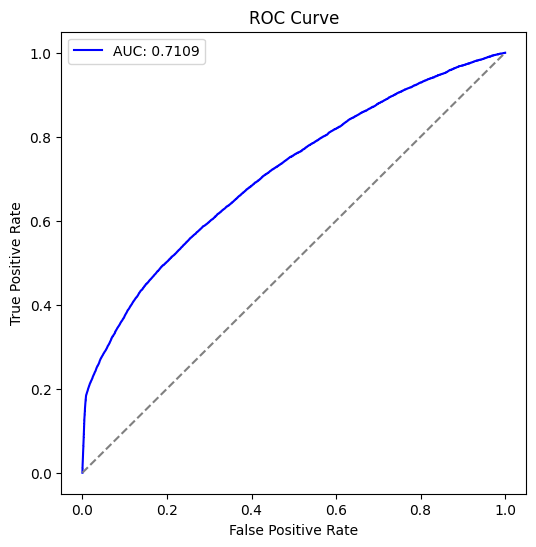

KS Statistic: 0.3037
Best Decision Threshold: 0.5000


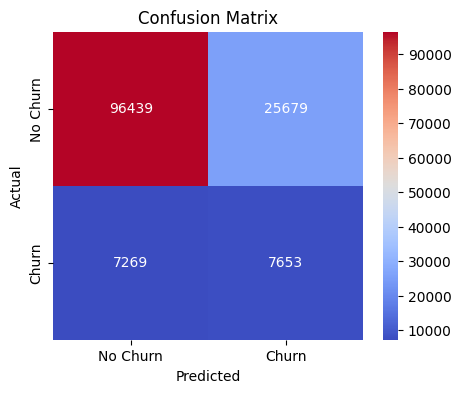


 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.79      0.85    122118
           1       0.23      0.51      0.32     14922

    accuracy                           0.76    137040
   macro avg       0.58      0.65      0.59    137040
weighted avg       0.85      0.76      0.80    137040


 Lift Table:


decile,count,events,avg_prob,event_rate,cumulative_events,cumulative_event_rate
0,13704,477,0.28181081270696484,0.03480735551663748,477,0.031966224366706875
1,13704,689,0.31967758602603663,0.05027729130180969,1166,0.07813965956306125
2,13704,818,0.3543573203591287,0.059690601284296554,1984,0.13295804851896528
3,13704,955,0.3889029295221866,0.06968768242848804,2939,0.1969575123978019
4,13704,997,0.4149310696645077,0.07275248102743724,3936,0.2637716123843989
5,13704,1185,0.4381646333569068,0.08647110332749562,5121,0.34318455971049455
6,13704,1319,0.4643750991525756,0.09624927028604786,6440,0.43157753652325426
7,13704,1508,0.4983526327576298,0.11004086398131932,7948,0.5326363758209355
8,13704,2117,0.5587218710525662,0.1544804436660829,10065,0.6745074386811419
9,13704,4857,0.7416383284829905,0.35442206654991243,14922,1.0


In [0]:
# KS Statistic Calculation
def ks_statistic(y_true, y_pred_prob):
    churn_probs = y_pred_prob[y_true == 1]
    non_churn_probs = y_pred_prob[y_true == 0]
    ks_stat, p_value = ks_2samp(churn_probs, non_churn_probs)
    return ks_stat

# Lift Table Calculation
def lift_table(y_true, y_pred_prob, bins=10):
    df = pd.DataFrame({"actual": y_true, "predicted_prob": y_pred_prob})
    df["decile"] = pd.qcut(df["predicted_prob"], bins, labels=False, duplicates="drop")
    
    lift_df = df.groupby("decile").agg(
        count=("actual", "count"),
        events=("actual", "sum"),
        avg_prob=("predicted_prob", "mean")
    ).reset_index()
    
    lift_df["event_rate"] = lift_df["events"] / lift_df["count"]
    lift_df["cumulative_events"] = lift_df["events"].cumsum()
    lift_df["cumulative_event_rate"] = lift_df["cumulative_events"] / lift_df["cumulative_events"].max()
    
    return lift_df

# Model Performance & Optimal Threshold Selection
def model_performance(y_test, y_pred_prob):
    auc = roc_auc_score(y_test, y_pred_prob)
    ks_stat = ks_statistic(y_test, y_pred_prob)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"AUC: {auc:.4f}", color="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
    
    print(f"KS Statistic: {ks_stat:.4f}")
    
    # Compute Best Threshold
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
    f1_scores = (2 * precision * recall) / (precision + recall)
    best_threshold = 0.5
    
    print(f"Best Decision Threshold: {best_threshold:.4f}")
    
    y_pred = (y_pred_prob >= best_threshold).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("\n Classification Report:")
    print(classification_report(y_test, y_pred))

    lift_df = lift_table(y_test, y_pred_prob)
    print("\n Lift Table:")
    display(lift_df)

model_performance(y_test, y_pred_prob)

In [0]:
# Cross-validation for better generalization using StratifiedKFold for faster execution
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_index, test_index in skf.split(X_train_top, y_train):
    X_train_fold, X_test_fold = X_train_top.iloc[train_index], X_train_top.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    catboost_final.fit(X_train_fold, y_train_fold, cat_features=categorical_cols_top)
    y_pred_prob_fold = catboost_final.predict_proba(X_test_fold)[:, 1]
    cv_scores.append(roc_auc_score(y_test_fold, y_pred_prob_fold))

print("Cross-Validation AUC:", np.mean(cv_scores))

0:	learn: 0.2574660	total: 55.3ms	remaining: 37.4s
100:	learn: 0.4569424	total: 3.83s	remaining: 21.9s
200:	learn: 0.4655916	total: 8.01s	remaining: 19s
300:	learn: 0.4800628	total: 12.2s	remaining: 15.3s
400:	learn: 0.4944293	total: 16.4s	remaining: 11.3s
500:	learn: 0.5020942	total: 20.6s	remaining: 7.24s
600:	learn: 0.5075393	total: 24.6s	remaining: 3.1s
676:	learn: 0.5109319	total: 27.7s	remaining: 0us
0:	learn: 0.2567330	total: 56.4ms	remaining: 38.2s
100:	learn: 0.4536335	total: 3.83s	remaining: 21.8s
200:	learn: 0.4669110	total: 8.02s	remaining: 19s
300:	learn: 0.4808586	total: 12.2s	remaining: 15.3s
400:	learn: 0.4985759	total: 16.4s	remaining: 11.3s
500:	learn: 0.5038953	total: 20.5s	remaining: 7.19s
600:	learn: 0.5078953	total: 24.6s	remaining: 3.12s
676:	learn: 0.5102408	total: 27.6s	remaining: 0us
0:	learn: 0.2580105	total: 54.4ms	remaining: 36.8s
100:	learn: 0.4515393	total: 3.91s	remaining: 22.3s
200:	learn: 0.4709319	total: 7.99s	remaining: 18.9s
300:	learn: 0.4809424	to

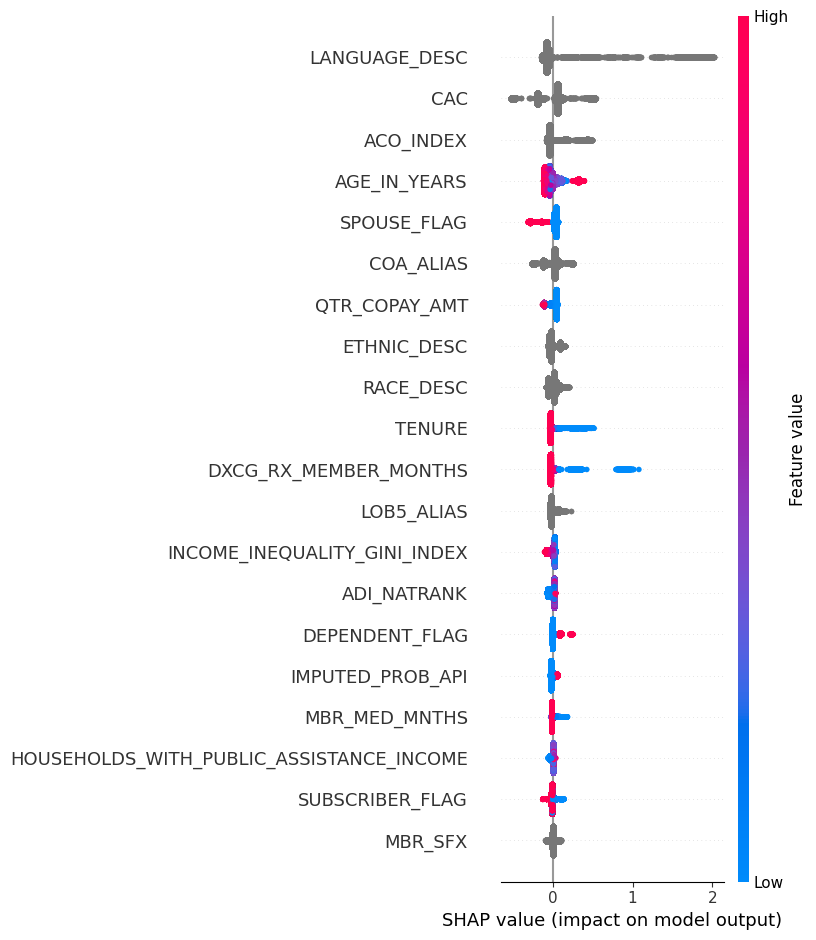

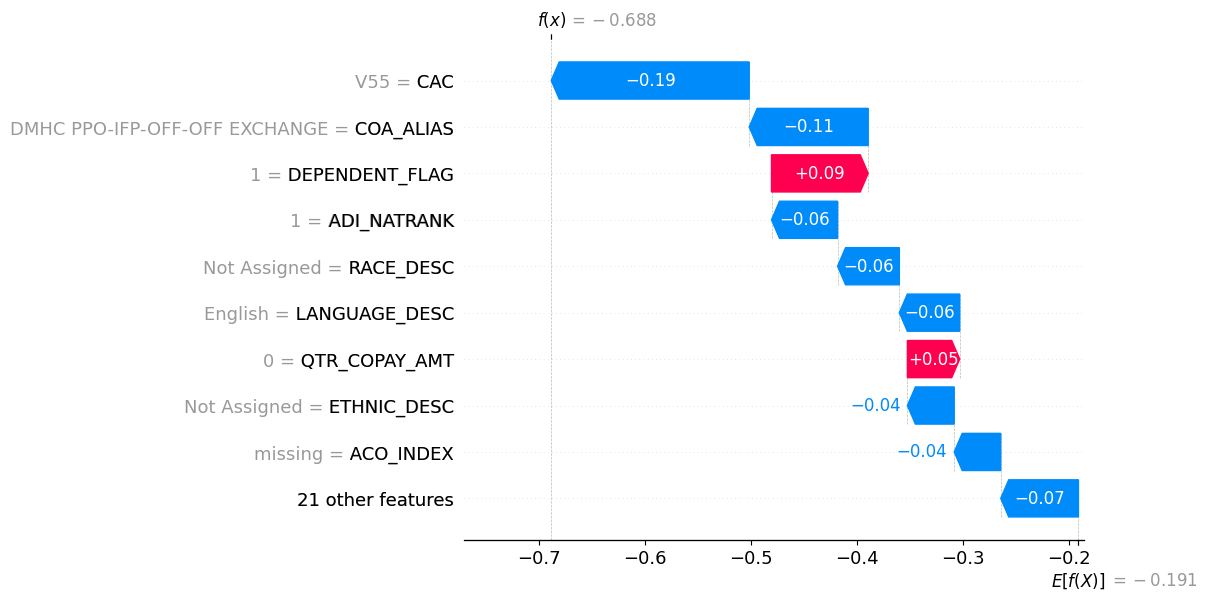

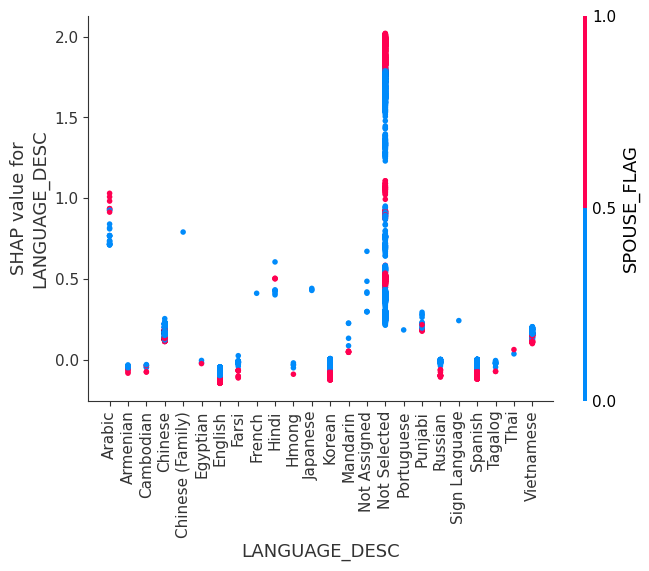

In [0]:
import shap
# Explain the model with SHAP
explainer = shap.TreeExplainer(catboost_final)
shap_values = explainer.shap_values(X_test_top)

# SHAP Summary Plot (Feature Importance)
shap.summary_plot(shap_values, X_test_top)

# SHAP Waterfall Plot (Explains one specific prediction)
shap.waterfall_plot(shap.Explanation(values=shap_values[0], base_values=explainer.expected_value, data=X_test_top.iloc[0]))

# SHAP Dependence Plot (Shows impact of a single feature)
shap.dependence_plot(top_30_features[0], shap_values, X_test_top)

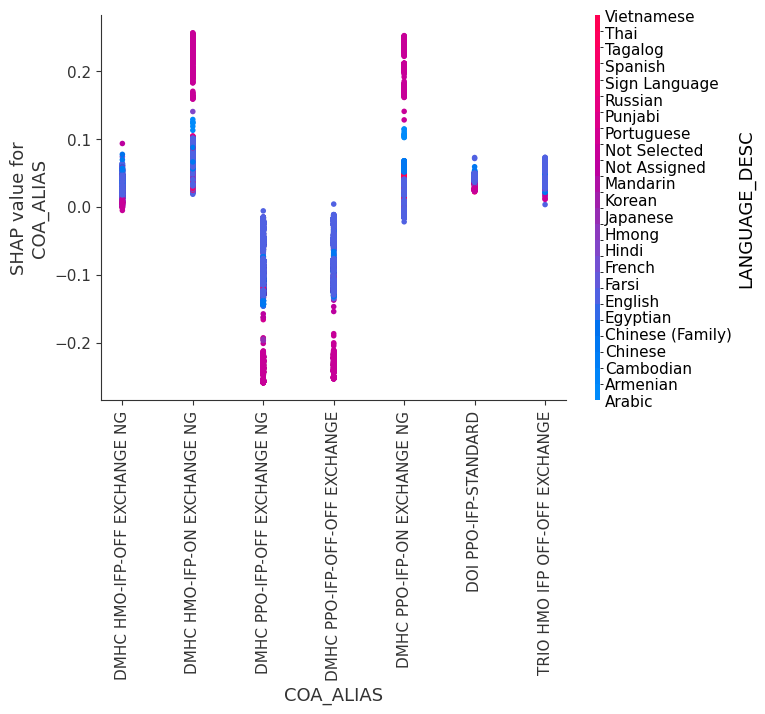

In [0]:
shap.dependence_plot(top_30_features[1], shap_values, X_test_top)

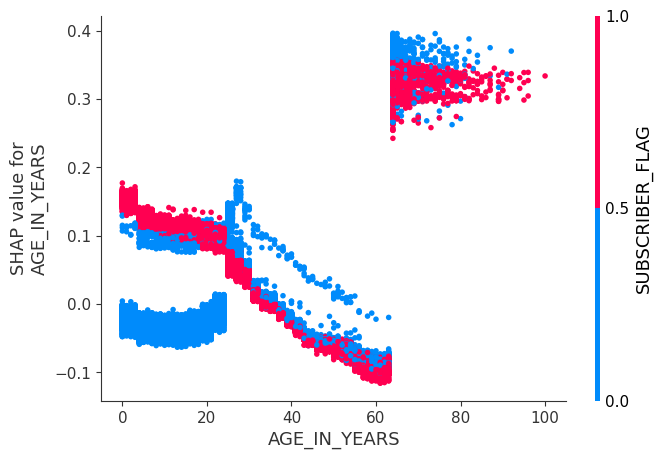

In [0]:
shap.dependence_plot(top_30_features[2], shap_values, X_test_top)

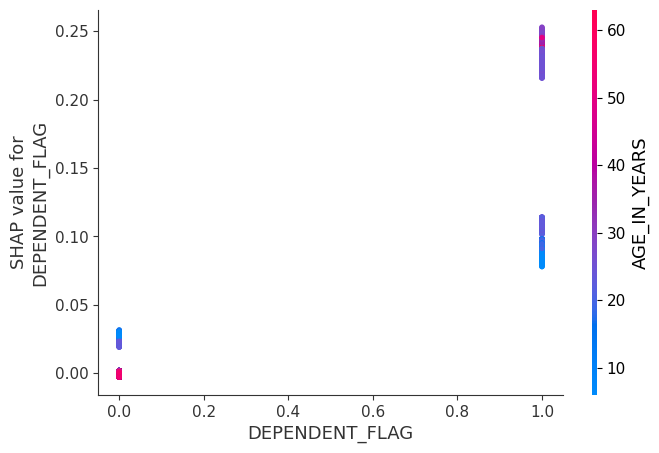

In [0]:
shap.dependence_plot(top_30_features[3], shap_values, X_test_top)

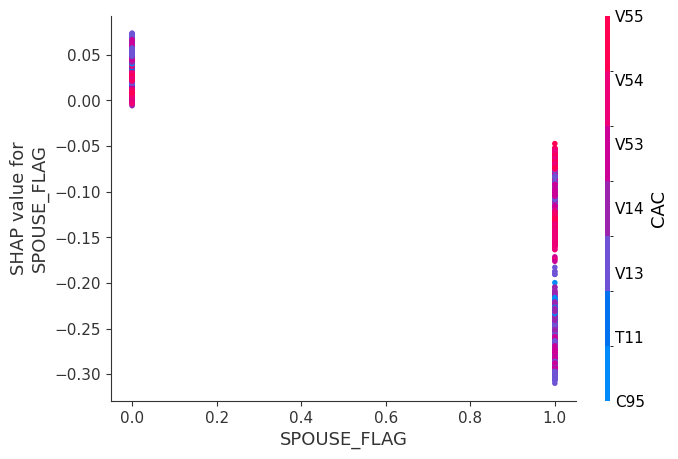

In [0]:
shap.dependence_plot(top_30_features[4], shap_values, X_test_top)

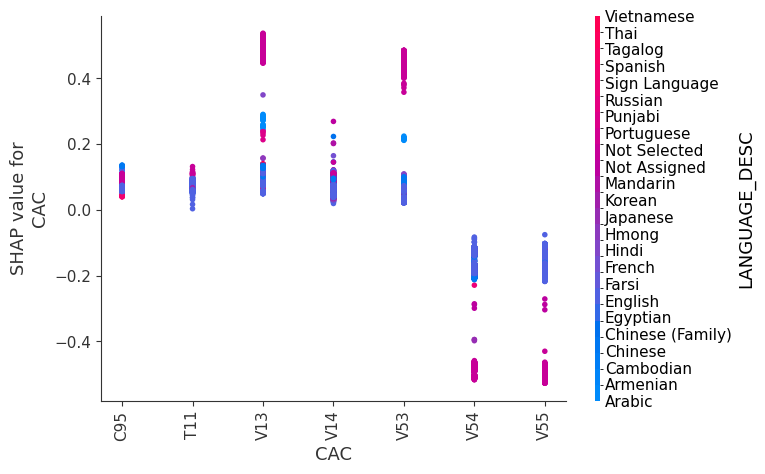

In [0]:
shap.dependence_plot(top_30_features[5], shap_values, X_test_top)

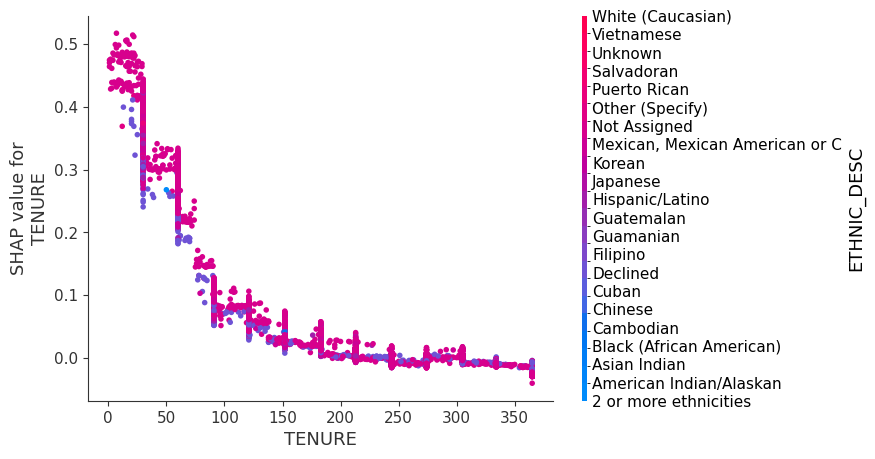

In [0]:
shap.dependence_plot(top_30_features[6], shap_values, X_test_top)

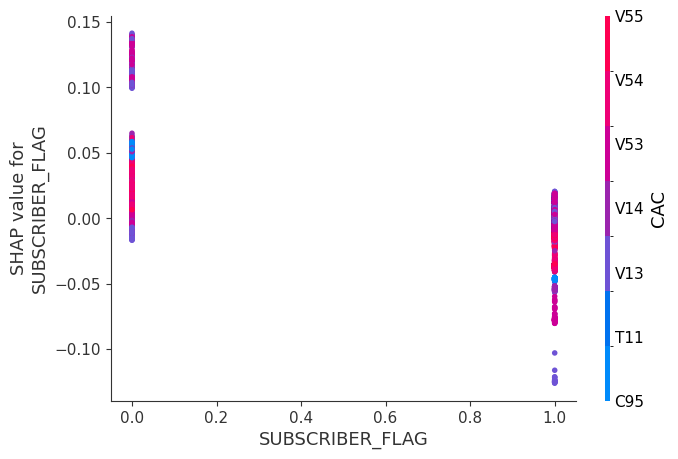

In [0]:
shap.dependence_plot(top_30_features[7], shap_values, X_test_top)

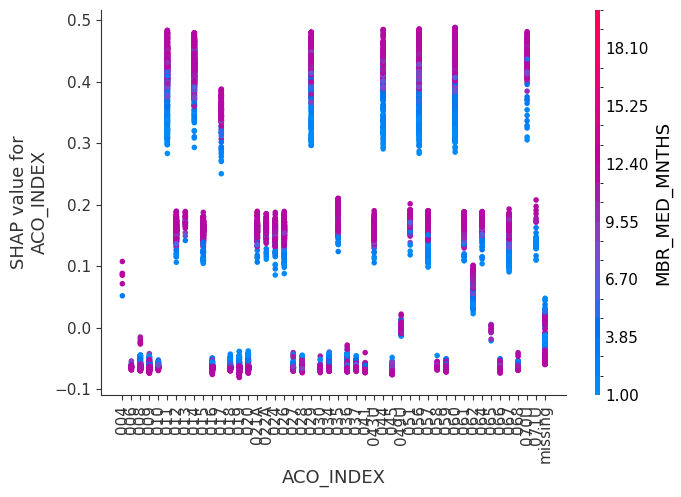

In [0]:
shap.dependence_plot(top_30_features[8], shap_values, X_test_top)

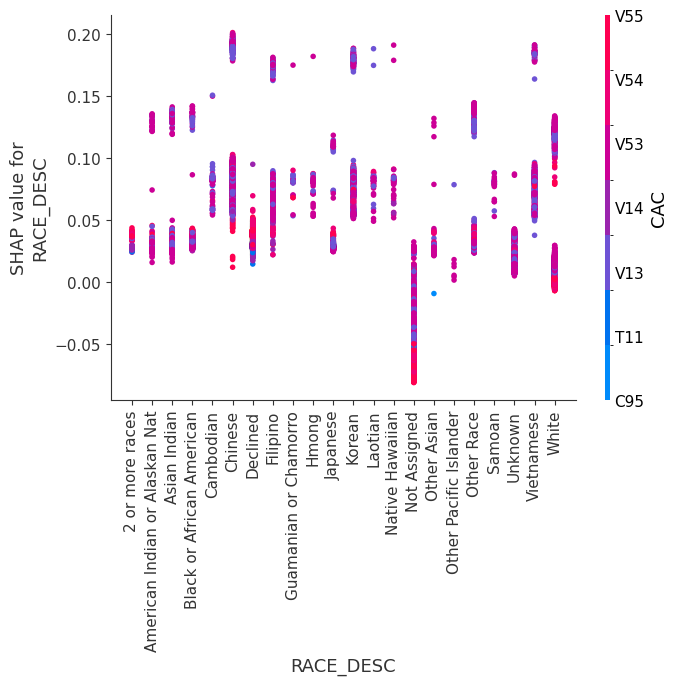

In [0]:
shap.dependence_plot(top_30_features[9], shap_values, X_test_top)

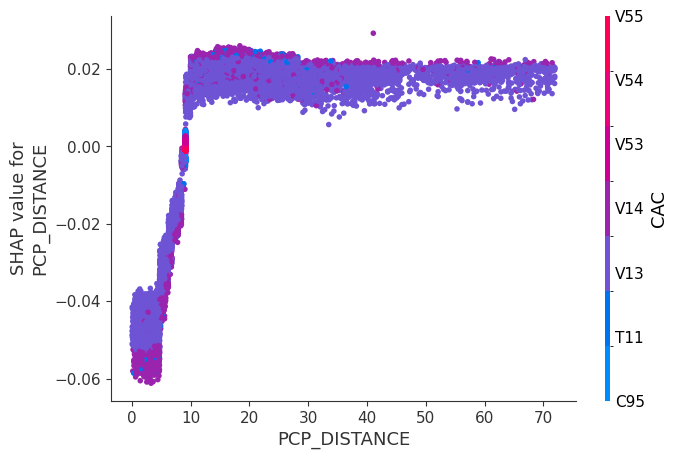

In [0]:
shap.dependence_plot(top_30_features[10], shap_values, X_test_top)

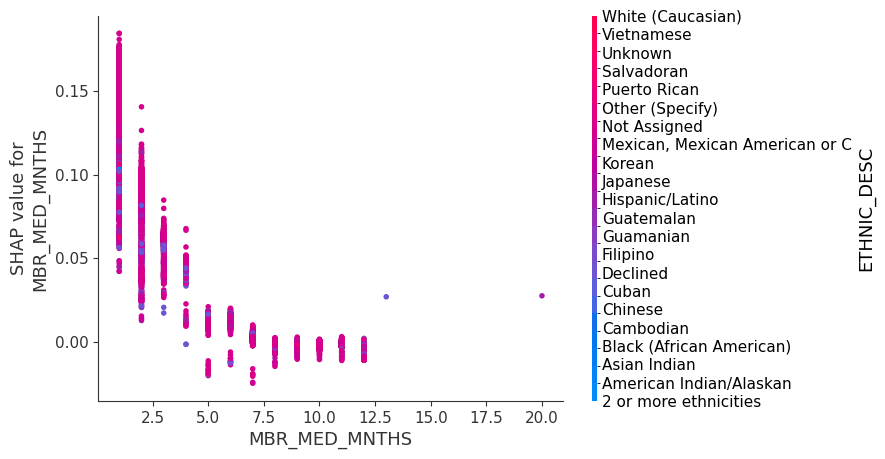

In [0]:
shap.dependence_plot(top_30_features[11], shap_values, X_test_top)

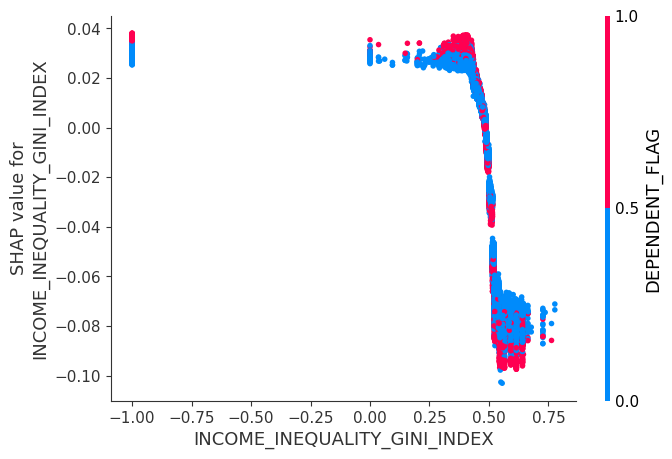

In [0]:
shap.dependence_plot(top_30_features[12], shap_values, X_test_top)

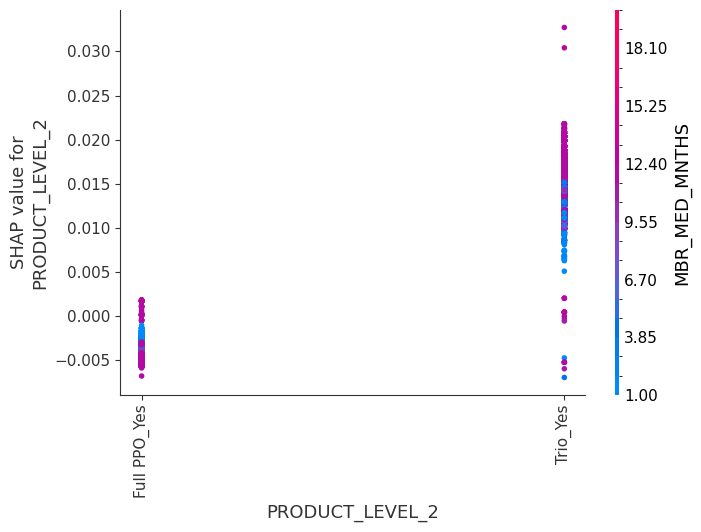

In [0]:
shap.dependence_plot(top_30_features[13], shap_values, X_test_top)

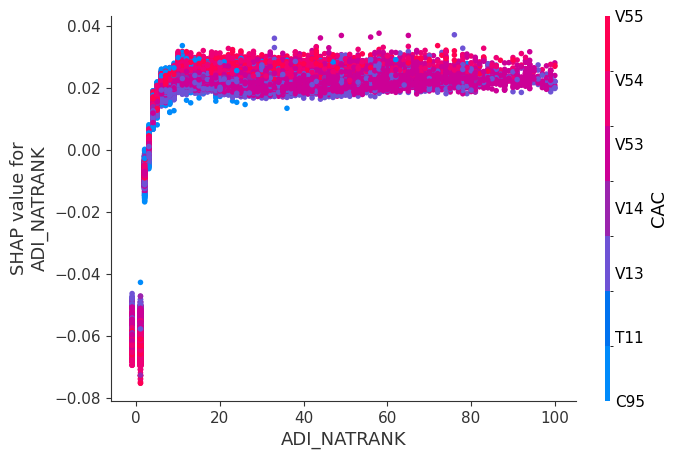

In [0]:
shap.dependence_plot(top_30_features[14], shap_values, X_test_top)

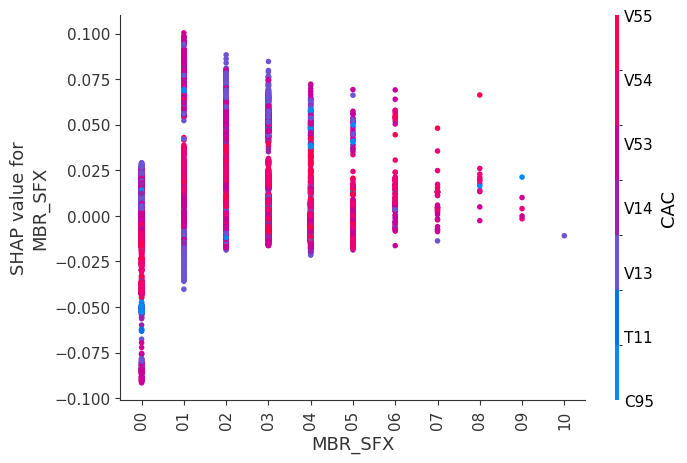

In [0]:
shap.dependence_plot(top_30_features[15], shap_values, X_test_top)

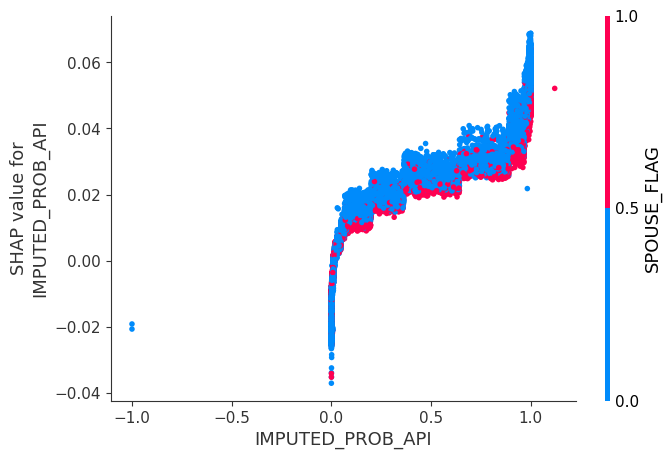

In [0]:
shap.dependence_plot(top_30_features[16], shap_values, X_test_top)

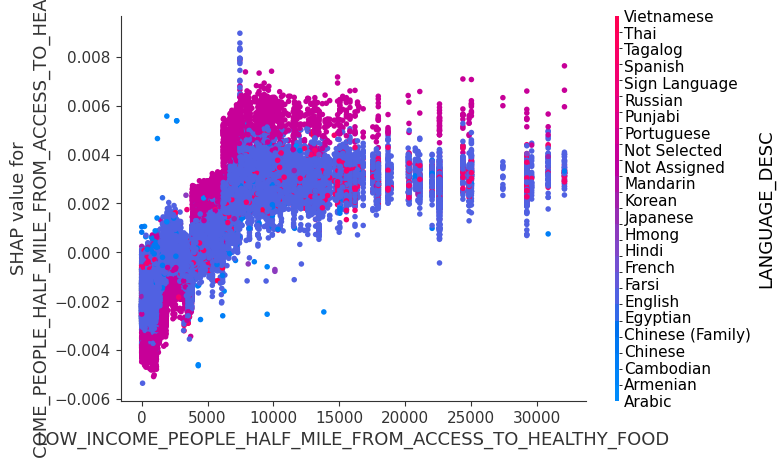

In [0]:
shap.dependence_plot(top_30_features[17], shap_values, X_test_top)

In [0]:
# Save the Trained Model for Deployment
joblib.dump(catboost_final, "/Volumes/dev_adb/ifp_churn/model/ifp_churn_model.pkl")
print("Model saved successfully")

Model saved successfully


In [0]:
# Load Model
catboost_loaded = joblib.load("/Volumes/dev_adb/ifp_churn/model/ifp_churn_model.pkl")

# Perform backtesting on 2021 to 2023 data
bt_df = df.filter(col('open_enrollment_cycle') != '2024').toPandas()

top_30_features = ['LANGUAGE_DESC', 'COA_ALIAS', 'AGE_IN_YEARS', 'DEPENDENT_FLAG', 'SPOUSE_FLAG', 'CAC', 'TENURE', 'SUBSCRIBER_FLAG', 'ACO_INDEX', 'RACE_DESC', 'PCP_DISTANCE', 'MBR_MED_MNTHS', 'INCOME_INEQUALITY_GINI_INDEX', 'PRODUCT_LEVEL_2', 'ADI_NATRANK', 'MBR_SFX', 'IMPUTED_PROB_API', 'LOW_INCOME_PEOPLE_HALF_MILE_FROM_ACCESS_TO_HEALTHY_FOOD', 'HOUSEHOLDS_WITHOUT_PUBLIC_ASSISTANCE_INCOME', 'HOUSEHOLDS_WITH_PUBLIC_ASSISTANCE_INCOME', 'ETHNIC_DESC', 'EP_DISABL', 'E_DAYPOP', 'PERCENTAGE_OF_LOW_INCOME_HALF_MILE_FROM_ACCESS_TO_HEALTHY_FOOD', 'PERCENTAGE_OF_LOW_INCOME_POPULATION', 'DXCG_RX_MEMBER_MONTHS', 'QTR_COPAY_AMT', 'E_DISABL', 'LOB5_ALIAS', 'EP_UNINSUR']

X_bt = bt_df[top_30_features]
y_bt = bt_df['churn_flag']

# Identify categorical columns
categorical_cols = X_bt.select_dtypes(include=["object", "category"]).columns.tolist()

# Convert categorical variables to strings (CatBoost handles them natively)
for col in categorical_cols:
    X_bt[col] = X_bt[col].astype(str)

bt_pool = Pool(data=X_bt, label=y_bt, cat_features=categorical_cols)

# Get predictions
y_pred_bt = catboost_loaded.predict_proba(bt_pool)[:, 1]

IOStream.flush timed out


Optimal Decision Threshold: 0.9889
Optimized ROC AUC Score: 0.6235
Optimized F1 Score: 0.0

Classification Report with Optimized Threshold:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94   1888844
           1       0.00      0.00      0.00    261653

    accuracy                           0.88   2150497
   macro avg       0.44      0.50      0.47   2150497
weighted avg       0.77      0.88      0.82   2150497



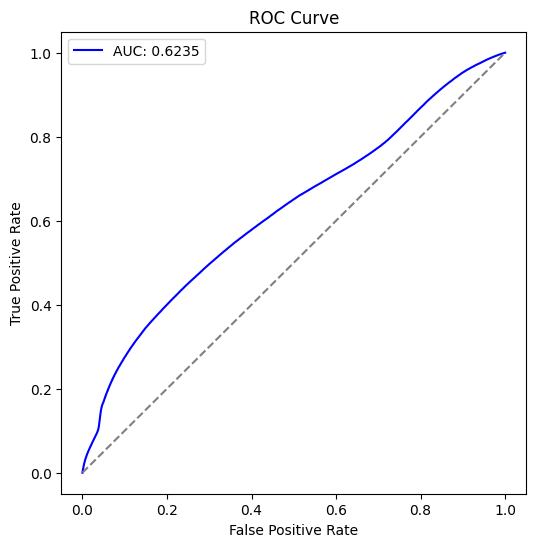

KS Statistic: 0.2011
Best Decision Threshold: 0.8000


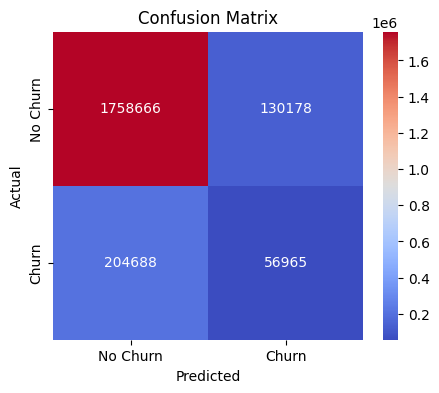


 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91   1888844
           1       0.30      0.22      0.25    261653

    accuracy                           0.84   2150497
   macro avg       0.60      0.57      0.58   2150497
weighted avg       0.82      0.84      0.83   2150497


 Lift Table:


decile,count,events,avg_prob,event_rate,cumulative_events,cumulative_event_rate
0,215050,13524,0.3279498278843721,0.06288770053475935,13524,0.05168677599721769
1,215050,22931,0.41959139740530554,0.10663101604278075,36455,0.13932574822379257
2,215049,24386,0.5059650440336226,0.11339741175267032,60841,0.232525520441195
3,215050,16971,0.575136021805941,0.07891653103929319,77812,0.2973862329115279
4,215050,16956,0.6127970635160837,0.07884677981864682,94768,0.3621896175469037
5,215049,19997,0.6430977836410833,0.09298810968662956,114765,0.43861526525589234
6,215051,22765,0.6699131707256434,0.10585861028314214,137530,0.5256198094422766
7,215048,26170,0.7014884430095718,0.12169376139280533,163700,0.6256377721638965
8,215050,34845,0.7472000828630724,0.1620320855614973,198545,0.7588103327689727
9,215050,63108,0.9069621055287596,0.29345733550337133,261653,1.0


In [0]:
# KS Statistic Calculation
def ks_statistic(y_true, y_pred_prob):
    churn_probs = y_pred_prob[y_true == 1]
    non_churn_probs = y_pred_prob[y_true == 0]
    ks_stat, p_value = ks_2samp(churn_probs, non_churn_probs)
    return ks_stat

# Lift Table Calculation
def lift_table(y_true, y_pred_prob, bins=10):
    df = pd.DataFrame({"actual": y_true, "predicted_prob": y_pred_prob})
    df["decile"] = pd.qcut(df["predicted_prob"], bins, labels=False, duplicates="drop")
    
    lift_df = df.groupby("decile").agg(
        count=("actual", "count"),
        events=("actual", "sum"),
        avg_prob=("predicted_prob", "mean")
    ).reset_index()
    
    lift_df["event_rate"] = lift_df["events"] / lift_df["count"]
    lift_df["cumulative_events"] = lift_df["events"].cumsum()
    lift_df["cumulative_event_rate"] = lift_df["cumulative_events"] / lift_df["cumulative_events"].max()
    
    return lift_df

# Model Performance & Optimal Threshold Selection
def model_performance(y_test, y_pred_prob):
    auc = roc_auc_score(y_test, y_pred_prob)
    ks_stat = ks_statistic(y_test, y_pred_prob)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"AUC: {auc:.4f}", color="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
    
    print(f"KS Statistic: {ks_stat:.4f}")
    
    # Compute Best Threshold
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
    f1_scores = (2 * precision * recall) / (precision + recall)
    best_threshold = 0.8
    
    print(f"Best Decision Threshold: {best_threshold:.4f}")
    
    y_pred = (y_pred_prob >= best_threshold).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("\n Classification Report:")
    print(classification_report(y_test, y_pred))

    lift_df = lift_table(y_test, y_pred_prob)
    print("\n Lift Table:")
    display(lift_df)

model_performance(y_bt, y_pred_bt)

In [0]:
# Defines function to predict churn probability & classify risk levels
def predict_churn(new_data):
    for col in categorical_cols:
        new_data[col] = new_data[col].astype(str)
    
    new_prob = catboost_loaded.predict_proba(new_data)[:, 1]
    
    risk_category = np.where(new_prob > 0.8, "High Risk",
                    np.where(new_prob > 0.5, "Medium Risk", "Low Risk"))
    
    return pd.DataFrame({"Churn Probability": new_prob, "Risk Category": risk_category})

# Classifies customers into High, Medium, Low risk groups
full_predictions = predict_churn(X_bt)

customer_segments = X_bt.copy()
customer_segments["Churn Probability"] = full_predictions["Churn Probability"]
customer_segments["Risk Category"] = full_predictions["Risk Category"]

print(customer_segments["Risk Category"].value_counts())

Medium Risk    1440457
Low Risk        522897
High Risk       187143
Name: Risk Category, dtype: int64


In [0]:
# Deploy Churn Prediction API using Flask
from flask import Flask, request, jsonify

app = Flask(__name__)

@app.route("/predict", methods=["POST"])
def predict():
    data = request.get_json()
    df = pd.DataFrame(data)

    # Identify categorical columns
    categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

    for col in categorical_cols_top:
        df[col] = df[col].astype(str)

    prob = catboost_loaded.predict_proba(df)[:, 1]
    risk_category = ["High Risk" if p > 0.8 else "Medium Risk" if p > 0.5 else "Low Risk" for p in prob]

    return jsonify({"churn_probability": prob.tolist(), "risk_category": risk_category})

if __name__ == "__main__":
    app.run(port=5000, debug=True)